# Step 7: Picking our Model.

In the previous section we decided to use transfer learning for our model. Now let's see which base model will give us the best result.

## 7.1: Loading the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pathlib
import os.path

data_dir =  pathlib.Path(os.path.abspath("images/Flowers5/"))
data_dir

WindowsPath('E:/school/UCSD-ML-Capstone/images/Flowers5')

In [3]:
batch_size = 32
epochs=15
img_height = 100
img_width = 100

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 1857 files belonging to 5 classes.
Using 1486 files for training.
Using 371 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes
print(class_names)

['Calceolaria', 'Daffodil', 'Freesia', 'Hibiscus', 'Iris']


## 7.2: Picking a Goal.

We will pick the model that has the best F1 score, which will ensure that our model has both good precision and recall.

In [6]:
from sklearn.metrics import f1_score as sk_f1

# Define our own function since we are working with batch datasets.
def f1_score(model):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # We iterate over the dataset to get the true label and input at the same time.
    # Otherwise we will unintentionally shuffle the dataset.
    for image_batch, label_batch in val_ds:
       y_true.append(label_batch)
       preds = model.predict(image_batch, verbose=0)
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    return sk_f1(correct_labels, predicted_labels, average=None)

## 7.3: Testing different models.

We will try learning from different pretained models, see which one performs the best, and then pick the one with the best F1 score.

**Note**: this section is skipping a few steps to speed up the training.
 * We are not doing data augmentation
 * We only run 5 epochs
 
 The point here is to compare the base models, we should hopefully get a good signals even with just a few epochs. \
 Models were found by asking Google BARD which would be the best models for image classification, and also BiT which comes from the research survey in the previous section.

In [7]:
# Creates a new model that learns from the specified mopdel.
def model_from_pretrained(pretrained_model):
    model = tf.keras.Sequential([
        layers.Rescaling(1./255), pretrained_model, layers.Flatten(), layers.Dense(64, activation='relu'), layers.Dropout(0.2), layers.Dense(num_classes),
    ])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss_fn, metrics=["accuracy"])
    model.build((None, img_height, img_width, 3))
    return model

In [8]:
def evaluate_model(name, model_url):
    print("Starting to train model:", name)
    model = model_from_pretrained(hub.KerasLayer(model_url))
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    
    f1 = f1_score(model)
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    print("Done training.")
    print("F1 score was:", np.mean(f1))
    
    del model


### BiT-S

Based on: A. Kolesnikov, L. Beyer, X. Zhai, J. Puigcerver, J. Yung, S. Gelly and N. Houlsby: [Big Transfer (BiT): General Visual Representation Learning.](https://arxiv.org/abs/1912.11370)

Starting to train model: BiT-S-R50x1
Epoch 1/15
47/47 [==============================] - 23s 219ms/step - loss: 0.9236 - accuracy: 0.6534 - val_loss: 0.5186 - val_accuracy: 0.8437
Epoch 2/15
47/47 [==============================] - 5s 106ms/step - loss: 0.4540 - accuracy: 0.8351 - val_loss: 0.3950 - val_accuracy: 0.8787
Epoch 3/15
47/47 [==============================] - 5s 105ms/step - loss: 0.2992 - accuracy: 0.9011 - val_loss: 0.3320 - val_accuracy: 0.8652
Epoch 4/15
47/47 [==============================] - 5s 105ms/step - loss: 0.2495 - accuracy: 0.9085 - val_loss: 0.2967 - val_accuracy: 0.9111
Epoch 5/15
47/47 [==============================] - 5s 105ms/step - loss: 0.1737 - accuracy: 0.9468 - val_loss: 0.2486 - val_accuracy: 0.9299
Epoch 6/15
47/47 [==============================] - 5s 106ms/step - loss: 0.1259 - accuracy: 0.9670 - val_loss: 0.2637 - val_accuracy: 0.9191
Epoch 7/15
47/47 [==============================] - 5s 106ms/step - loss: 0.1212 - accuracy: 0.9650 - val_loss

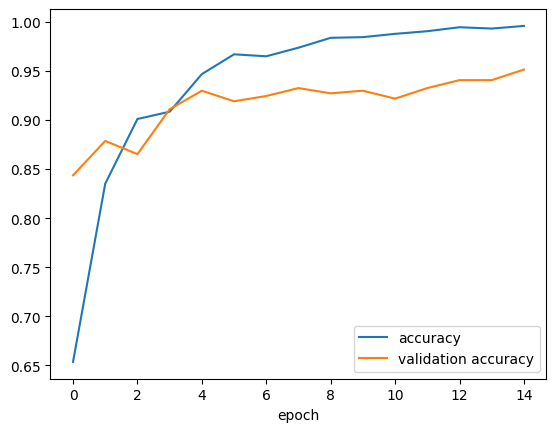

Done training.
F1 score was: 0.9516259951379867


In [9]:
evaluate_model("BiT-S-R50x1", "https://tfhub.dev/google/bit/s-r50x1/1")

Starting to train model: BiT-S-R50x3
Epoch 1/15
47/47 [==============================] - 28s 346ms/step - loss: 0.9227 - accuracy: 0.6528 - val_loss: 0.5438 - val_accuracy: 0.8086
Epoch 2/15
47/47 [==============================] - 15s 309ms/step - loss: 0.4744 - accuracy: 0.8244 - val_loss: 0.4410 - val_accuracy: 0.8518
Epoch 3/15
47/47 [==============================] - 15s 316ms/step - loss: 0.3170 - accuracy: 0.8943 - val_loss: 0.3504 - val_accuracy: 0.8679
Epoch 4/15
47/47 [==============================] - 15s 311ms/step - loss: 0.2528 - accuracy: 0.9192 - val_loss: 0.3591 - val_accuracy: 0.8787
Epoch 5/15
47/47 [==============================] - 15s 315ms/step - loss: 0.2021 - accuracy: 0.9408 - val_loss: 0.3455 - val_accuracy: 0.8706
Epoch 6/15
47/47 [==============================] - 15s 314ms/step - loss: 0.1808 - accuracy: 0.9388 - val_loss: 0.3653 - val_accuracy: 0.9003
Epoch 7/15
47/47 [==============================] - 15s 315ms/step - loss: 0.1227 - accuracy: 0.9697 - va

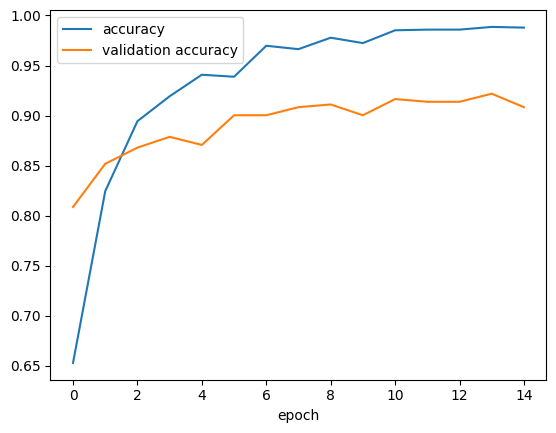

Done training.
F1 score was: 0.9073964996653612


In [11]:
evaluate_model("BiT-S-R50x3", "https://tfhub.dev/google/bit/s-r50x3/1")

Starting to train model: BiT-S-R101x1
Epoch 1/15
47/47 [==============================] - 87s 1s/step - loss: 0.9570 - accuracy: 0.6460 - val_loss: 0.5799 - val_accuracy: 0.8059
Epoch 2/15
47/47 [==============================] - 63s 1s/step - loss: 0.4416 - accuracy: 0.8331 - val_loss: 0.4985 - val_accuracy: 0.8329
Epoch 3/15
47/47 [==============================] - 63s 1s/step - loss: 0.3320 - accuracy: 0.8843 - val_loss: 0.4303 - val_accuracy: 0.8464
Epoch 4/15
47/47 [==============================] - 63s 1s/step - loss: 0.2365 - accuracy: 0.9139 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 5/15
47/47 [==============================] - 63s 1s/step - loss: 0.1733 - accuracy: 0.9468 - val_loss: 0.3565 - val_accuracy: 0.8868
Epoch 6/15
47/47 [==============================] - 63s 1s/step - loss: 0.1385 - accuracy: 0.9630 - val_loss: 0.3368 - val_accuracy: 0.9003
Epoch 7/15
47/47 [==============================] - 63s 1s/step - loss: 0.1126 - accuracy: 0.9724 - val_loss: 0.3160 - val

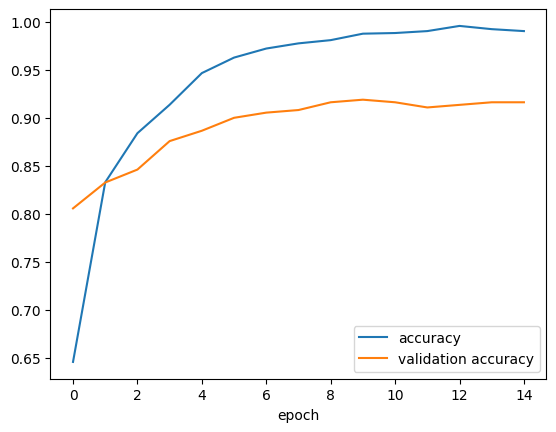

Done training.
F1 score was: 0.9152356239040806


In [9]:
evaluate_model("BiT-S-R101x1", "https://tfhub.dev/google/bit/s-r101x1/1")

### Inception V3

Starting to train model: InceptionV3
Epoch 1/15
47/47 [==============================] - 13s 200ms/step - loss: 1.4612 - accuracy: 0.5330 - val_loss: 0.9550 - val_accuracy: 0.6658
Epoch 2/15
47/47 [==============================] - 9s 184ms/step - loss: 0.7808 - accuracy: 0.7093 - val_loss: 0.8242 - val_accuracy: 0.7089
Epoch 3/15
47/47 [==============================] - 9s 184ms/step - loss: 0.5740 - accuracy: 0.7853 - val_loss: 0.7511 - val_accuracy: 0.7439
Epoch 4/15
47/47 [==============================] - 9s 184ms/step - loss: 0.4706 - accuracy: 0.8311 - val_loss: 0.6639 - val_accuracy: 0.7547
Epoch 5/15
47/47 [==============================] - 9s 184ms/step - loss: 0.3721 - accuracy: 0.8762 - val_loss: 0.6952 - val_accuracy: 0.7763
Epoch 6/15
47/47 [==============================] - 9s 184ms/step - loss: 0.3160 - accuracy: 0.9044 - val_loss: 0.6735 - val_accuracy: 0.7763
Epoch 7/15
47/47 [==============================] - 9s 183ms/step - loss: 0.2597 - accuracy: 0.9152 - val_loss

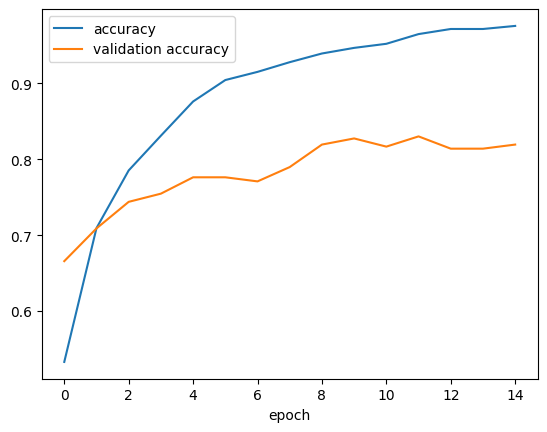

Done training.
F1 score was: 0.8175223743571263


In [10]:
evaluate_model("InceptionV3", "https://tfhub.dev/google/imagenet/inception_v3/classification/5")

### EfficientNetB0

Starting to train model: EfficientNetB0
Epoch 1/15
47/47 [==============================] - 24s 362ms/step - loss: 1.5855 - accuracy: 0.4058 - val_loss: 1.5585 - val_accuracy: 0.4933
Epoch 2/15
47/47 [==============================] - 16s 339ms/step - loss: 1.5213 - accuracy: 0.5182 - val_loss: 1.4834 - val_accuracy: 0.5445
Epoch 3/15
47/47 [==============================] - 16s 339ms/step - loss: 1.4319 - accuracy: 0.5491 - val_loss: 1.3885 - val_accuracy: 0.5741
Epoch 4/15
47/47 [==============================] - 16s 339ms/step - loss: 1.3343 - accuracy: 0.5707 - val_loss: 1.2941 - val_accuracy: 0.6092
Epoch 5/15
47/47 [==============================] - 16s 339ms/step - loss: 1.2384 - accuracy: 0.6003 - val_loss: 1.2145 - val_accuracy: 0.6280
Epoch 6/15
47/47 [==============================] - 16s 339ms/step - loss: 1.1664 - accuracy: 0.6023 - val_loss: 1.1523 - val_accuracy: 0.6334
Epoch 7/15
47/47 [==============================] - 16s 338ms/step - loss: 1.1056 - accuracy: 0.6252 -

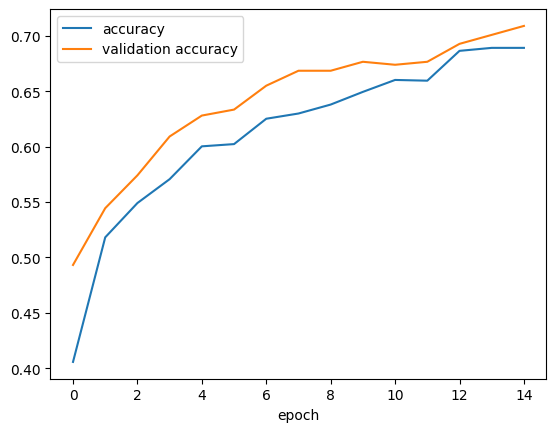

Done training.
F1 score was: 0.7058572744859724


In [11]:
evaluate_model("EfficientNetB0", "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")

Starting to train model: ResNet50
Epoch 1/15
47/47 [==============================] - 29s 540ms/step - loss: 1.4344 - accuracy: 0.5478 - val_loss: 0.8141 - val_accuracy: 0.7035
Epoch 2/15
47/47 [==============================] - 25s 521ms/step - loss: 0.6935 - accuracy: 0.7376 - val_loss: 0.6758 - val_accuracy: 0.7601
Epoch 3/15
47/47 [==============================] - 24s 520ms/step - loss: 0.5382 - accuracy: 0.8035 - val_loss: 0.6026 - val_accuracy: 0.7736
Epoch 4/15
47/47 [==============================] - 24s 519ms/step - loss: 0.4481 - accuracy: 0.8466 - val_loss: 0.5533 - val_accuracy: 0.8086
Epoch 5/15
47/47 [==============================] - 24s 517ms/step - loss: 0.3907 - accuracy: 0.8526 - val_loss: 0.5964 - val_accuracy: 0.8086
Epoch 6/15
47/47 [==============================] - 24s 516ms/step - loss: 0.3545 - accuracy: 0.8809 - val_loss: 0.4928 - val_accuracy: 0.8464
Epoch 7/15
47/47 [==============================] - 24s 517ms/step - loss: 0.2979 - accuracy: 0.8930 - val_l

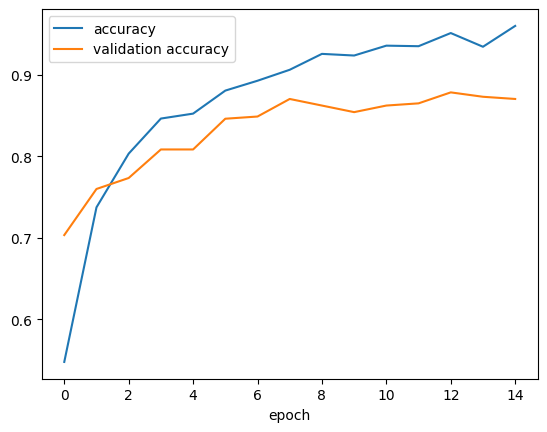

Done training.
F1 score was: 0.8707690173524313


In [12]:
evaluate_model("ResNet50", "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5")

### Results

In [10]:
import pandas as pd
results_df = pd.DataFrame.from_dict({
    "model": 
        ["BiT-S-R50x1", "BiT-S-R50x3", "BiT-S-R101x1", "InceptionV3", "EfficientNetB0", "ResNet50"],
    "f1_score":
        [0.9516259951379867, 0.00, 0.9152356239040806, 0.8175223743571263, 0.7058572744859724, 0.8707690173524313],
})
results_df.sort_values('f1_score')

,model,f1_score
3,EfficientNetB0,0.705857
2,InceptionV3,0.817522
4,ResNet50,0.870769
1,BiT-S-R101x1,0.915236
0,BiT-S-R50x1,0.951626


Looks like the BiT model had the best performance. Note that there are even larger BiT models that we can consider using. May be worthwhile once we scale up to the whole dataset.